# Multi-LoRA

---

In this lesson, we'll see how to efficiently serve dozens of fine-tuned models together in a single deployment without sacrificing latency.

<img src="../../../images/multi-lora-usecases.png" alt="Multi-LoRA Usecases" style="width: 50%; height: auto;"/>

## Import required packages

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

## Let's create a new model

In [2]:
class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # hidden_size = 10
        # set this so low to ensure we are not 
        # compute-bound by the linear layer
        # this is only an issue when running on CPU, 
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, rank)
        loras_b: torch.Tensor,           # (num_loras, rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        # y[i] = x[i] @ loras_a[lora_idx] @ loras_b[lora_idx]
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices)
        x = self.lm_head(x)
        return x

## Using a loop

Our first attempt to infer across multiple LoRAs will be straightforward: just loop over every row in the batch and apply the correct LoRA using an index mapping: `batch_index --> lora_index`.

In [3]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y

In [4]:
# toy example of a detokenizer. The vocabular only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [5]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [6]:
torch.manual_seed(42)

In [7]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [8]:
model = LoopMultiLoraModel()

## Let's try it!

We will try this over a few random LoRAs using a fixed tensor of input_ids. If our multi-LoRA generation process is working as designed, we should see a variety of different outputs generated as we randomly iterate over the LoRAs.

In [9]:
# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for 64 random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    next_token = generate_token(
        model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices,
    )
    print(next_token)

['orange']
['red']
['chartreuse']
['yellow']
['marigold']
['yellow']
['red']
['orange']
['violet']
['red']


## Let's benchmark our multi-LoRA system!

We will measure the average latency to generate a single token as the batch size increases and each element within the batch can have a different LoRA adapter (chosen randomly).

In [10]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for 
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

In [11]:
avg_latencies_loop = benchmark(model)

1 0.0012195749282836914
2 0.0015347247123718261
3 0.0015708274841308594
4 0.001956471920013428
5 0.002098774433135986
6 0.0020843391418457033
7 0.0023744258880615235
8 0.0027190380096435546
9 0.001971107006072998
10 0.0018185486793518067
11 0.0016849994659423827
12 0.0021281256675720213
13 0.002266580104827881
14 0.002111313819885254
15 0.002278706073760986
16 0.002359787940979004
17 0.0024987711906433105
18 0.0031396679878234863
19 0.0026628384590148928
20 0.002929085731506348
21 0.0030347814559936524
22 0.0032071537971496583
23 0.0031132345199584963
24 0.0037173433303833007
25 0.003682448863983154
26 0.0034818835258483886
27 0.0036057467460632324
28 0.004416981220245361
29 0.0037397680282592774
30 0.004039171695709228
31 0.004785627841949463
32 0.004969919204711914
33 0.0048060302734375
34 0.004287485599517822
35 0.004590779781341553
36 0.003775371551513672
37 0.0038387842178344727
38 0.004560571670532226
39 0.004887636661529541
40 0.00357615327835083
41 0.004928439617156982
42 0.005

## Let's visualize it!

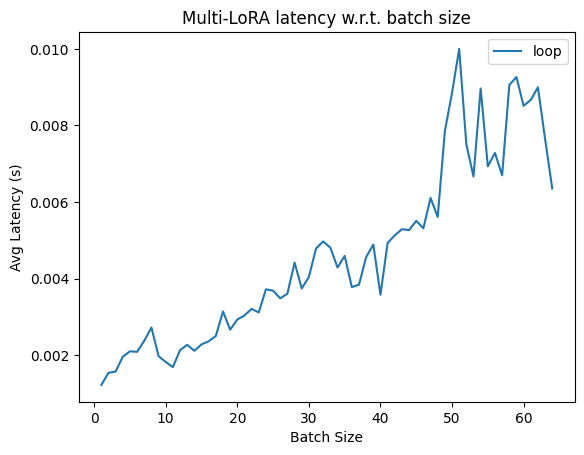

In [12]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

## Let's vectorize the LoRA computation

We will vectorize the LoRA computation by:

- Gather the LoRA weight for each batch into a single tensor using `torch.index_select`.
- Apply LoRA computation once for the entire input tensor.

In [13]:
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        
        # gather the LoRA weights into a new tensor and apply
        lora_a = torch.index_select(loras_a, 0, lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, 0, lora_indices) # (batch_size, lora_rank, out_features)
        y += x @ lora_a @ lora_b
        return y

In [14]:
model = GatheredMultiLoraModel()

In [15]:
avg_latencies_gathered = benchmark(model)

1 0.0004895839691162109
2 0.0007507205009460449
3 0.0006586823463439941
4 0.00047607994079589845
5 0.000552058219909668
6 0.0032459716796875
7 0.0006917076110839844
8 0.0006324982643127441
9 0.0005638222694396973
10 0.0006744108200073243
11 0.0008092527389526367
12 0.0007460246086120606
13 0.0007921299934387207
14 0.0007547283172607422
15 0.0007164044380187989
16 0.0007577128410339355
17 0.0018102383613586425
18 0.0016859707832336426
19 0.0007272248268127442
20 0.0008521900177001953
21 0.0007857327461242675
22 0.001822239875793457
23 0.0008387799263000488
24 0.0007429924011230468
25 0.0008440418243408203
26 0.0010526609420776368
27 0.0009171342849731445
28 0.0009255952835083008
29 0.0010859465599060059
30 0.0012070927619934081
31 0.0010100526809692382
32 0.001528306007385254
33 0.001304600715637207
34 0.0018137044906616211
35 0.0014419174194335938
36 0.0020192646980285644
37 0.0018961591720581055
38 0.001491262435913086
39 0.0018763904571533203
40 0.0018842768669128417
41 0.00186571359

## Let's visualize it!

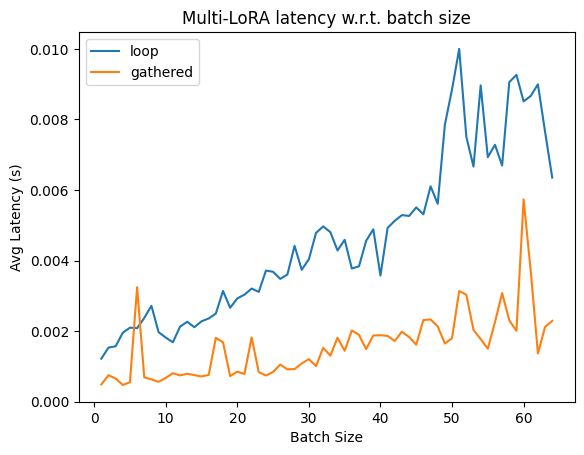

In [16]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

## Additional optimization steps

- Support LORA adapters of different ranks
- Support mixed batches of requests with and without LORA adapters
- Improve efficiency of index select step
- Organize by "segments" of same requested LORA adapter to reduce copies in memory
- Implement as CUDA kernel rather than in PyTorch for improved performance